In [53]:
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections

import uafgi.data.w21
importlib.reload(uafgi.data.w21)

<module 'uafgi.data.w21' from '/Users/eafischer2/harn/pismip6/uafgi/uafgi/data/w21.py'>

In [139]:
df = pd.read_pickle('outputs/stability/stability.df')    # many rows
select = pd.read_pickle('outputs/stability/03_select.df')   # Just 23 rows
df = pd.merge(df, select, how='left', on='ns642_key', suffixes=(None,'_DELETEME'))
drops = [x for x in df.columns if x.endswith('_DELETEME')]
df = df.drop(drops, axis=1)
print(len(df))

3864


In [140]:
df.columns

Index(['success', 'error_msg', 'ns481_grid', 'velocity_file', 'year',
       'sigma_max', 'w21_popular_name', 'w21_greenlandic_name', 'w21_coast',
       'w21_category', 'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs',
       'w21_Qc_inferred', 'w21_qm', 'w21_qf', 'w21_qc', 'w21_mean_depth',
       'w21_min_depth', 'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_me

In [109]:
select[['w21_popular_name', 'w21_category', 'w21_mean_undercutting_2008_2017', 'ns481_key', 'retreat_rate']]\
  .sort_values(['w21_category','w21_mean_undercutting_2008_2017'])


,w21_popular_name,w21_category,w21_mean_undercutting_2008_2017,ns481_key,retreat_rate
6,Ussing Br.,CR,0.88,W73.75N,-26.064922
18,Skinfaxe Gl.,CR,0.94,E63.35N,0.242703
22,Upernavik Isstrom S,CR,1.03,W72.90N,-19.585277
10,Rimfaxe Gl.,CR,1.06,E63.35N,2.304114
15,Store Gl.,CR,1.29,W70.55N,10.092501
12,Kangiata Nunaata Se.,CR,1.50,W64.25N,-107.534485
14,Rink Isbrae,CR,1.78,W71.65N,-31.616169
2,Perlerfiup Se.,DW,0.70,W70.90N,-244.187242
0,F. Graae Gl.,DW,0.73,E71.75N,-62.792085
19,Kangerlussuaq Gl.,DW,1.10,E68.80N,-304.035157


In [171]:
# apply linear regresion using numpy
def linReg(x, y):
    '''linear regression using numpy starting from two one dimensional numpy arrays'''
    A = np.vstack([x, np.ones(len(x))]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return pd.Series({'slope':slope, 'intercept': intercept})

def lrr(row):
    """Linear regression on a row"""
    seconds0 = np.array(list(x.timestamp() for x in row.stab_time))
    ice0 = np.array(row.stab_ice) / (row.w21_mean_fjord_width * 1000.)
    
    seconds = seconds0 - seconds0[0]
    days = seconds / 86400.
    years = days / 365.
    ice = ice0 - ice0[0]    
    keep = (seconds > 30*86400)

    return linReg(years, ice)[['slope']]

def advet_rate(df1):
    """Interpolates timeseries during each (year,glacier) run to
    produce an experimental advance/retreat rate over the course of the run.
    
    df1: (year, ns642_GlacierID, sigma_max)
        The original experiment dataframe
    Returns:
        Series of the rate of advance / retreat for each model run in df1
        
    NOTE: To graph per-glacier, do:
        df['advet_rate'] = advret_rate(df)
        df.pivot(index='sigma_max', columns='year', values='advret_rate').plot(figsize=(10,6))
    """    
    return df1.apply(lrr, axis=1)

def sigma_eq(df1):
    """Determines the slope and y-intercept of different values of sigma_max for each year.

    df1: (year, ns642_GlacierID, sigma_max)
        The original experiment dataframe, with advret_rate column added (see above)
    Returns: DatFrame(year, ns642_GlacierID)
        sigma_eq:
            sigma_max value that results in no advance/retreat
        dadv_dsigma:
            Change in advret_rate vs. change in sigma_max
    """
    
    dfg = df1.groupby(['ns642_GlacierID', 'year'])
    rows = list()
    for (glacier_id, year), dfx in dfg:
        row = {'ns642_GlacierID' : glacier_id, 'year' : year}
        row['poly_abc'] = abc = np.polyfit(dfx['sigma_max'], dfx['advret_rate'], 3)
        ab = np.polyder(abc)     # Derivative of abc
        rootsx = [np.real(x) for x in np.roots(abc) if ~np.iscomplex(x) and x >= 100000 and x <= 500000]
        if len(rootsx) > 0:
            row['sigma_eq'] = root = rootsx[0]
            row['dadv_dsigma'] = np.poly1d(ab)(root)
        rows.append(row)

    return pd.DataFrame(rows)

def glacier_stats(df):
    df['advet_rate'] = advet_rate(df)
    rs = sigma_eq(df)

    # Compute the plot
    plotdf = df.pivot(index='sigma_max', columns='year', values='advret_rate')
    
    # Compute stats on a (glacier_id) basis
    stats=rs.groupby(['ns642_GlacierID']).agg({'sigma_eq': ['mean','std'], 'dadv_dsigma': ['mean','std']})
    # https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
    stats.columns = ['_'.join(col).strip() for col in xx.columns.values]
    stats = xx.reset_index()

    return plotdf,stats




In [172]:
df['advet_rate'] = advet_rate(df)
rs = sigma_eq(df1)
rs

,ns642_GlacierID,year,poly_abc,sigma_eq,dadv_dsigma
0,3,2011,"[8.751296423245184e-14, -1.29473896293081e-07,...",207691.682550,0.025175
1,3,2012,"[5.257937557846672e-14, -6.536155340332344e-08...",NaN,NaN
2,3,2013,"[2.0100993724556192e-13, -2.3967159097224774e-...",226362.525016,0.024472
3,3,2014,"[1.5446466219565766e-13, -1.7844269997883291e-...",302433.424479,0.012568
4,3,2015,"[2.8419058011112154e-13, -2.93966826664103e-07...",214977.027987,0.018354
...,...,...,...,...,...
179,207,2014,"[9.931759597446036e-14, -1.54406133956196e-07,...",194468.800184,0.033104
180,207,2015,"[1.0726140584614734e-13, -1.6063780827888838e-...",188520.284781,0.032494
181,207,2016,"[1.773964484535026e-13, -2.14918437735822e-07,...",207183.567605,0.027069
182,207,2017,"[1.0380083344650028e-13, -1.630074283200269e-0...",211955.923133,0.030691


In [175]:
xx=rs.groupby(['ns642_GlacierID']).agg({'sigma_eq': ['mean','std'], 'dadv_dsigma': ['mean','std']})
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
xx.columns = ['_'.join(col).strip() for col in xx.columns.values]
xx = xx.reset_index()


,ns642_GlacierID,sigma_eq_mean,sigma_eq_std,dadv_dsigma_mean,dadv_dsigma_std
0,3,229779.347053,39659.300169,0.019896,0.004665
1,8,206191.227822,11632.070378,0.010525,0.001852
2,9,167408.685798,3969.340982,0.024342,0.002880
3,12,209944.347226,15573.679955,0.001230,0.000181
4,14,331427.763838,151786.603029,0.001233,0.000903
5,17,153196.940863,9719.820395,0.026087,0.002289
6,21,229353.735876,17701.697950,0.006029,0.001189
7,22,188108.683149,15882.792063,0.017940,0.003927
8,23,236014.579558,83870.134186,0.018467,0.007158
9,30,185637.540691,13958.761711,0.004891,0.000465


Kangiata Nunaata Se.: type=CR  coast=SW
   Calving Ridge, independent of the presence of AW (warm Atlantic waters)
Adv/Ret rate (negative is retreat): -107.53448540724511 m/a
Undercut rate = 1.5
curvature -526368.2089074807


KeyError: 2017

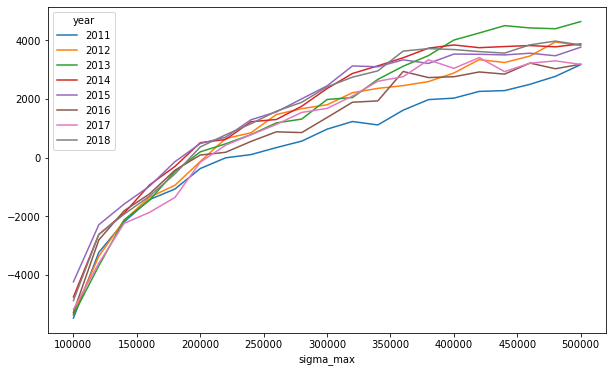

In [122]:
import matplotlib.pyplot as plt
df1g = df.groupby(['ns642_GlacierID'])
# Get first group for now
#print(df1g.get_group(17))
#for glacier_id,df2 in df1g:
sorted = select.sort_values(['w21_category','retreat_rate'])
for ix,row in sorted.iterrows():
    df2 = df1g.get_group(row['ns642_GlacierID'])
    name = row['w21_popular_name']
    retreat_rate = row['retreat_rate']
    year = 2017
    gs = glacier_stability(df2)
    gs.pivot(index='sigma_max', columns='year', values='advret_rate').plot(figsize=(10,6))


#    print(gs)
    category = row['w21_category']
    print('{}: type={}  coast={}'.format(name, category, row['w21_coast']))
    print('   {}'.format(uafgi.data.w21.category_descr[category]))
    print('Adv/Ret rate (negative is retreat): {} m/a'.format(retreat_rate))
    print('Undercut rate = {}'.format(row['w21_mean_undercutting_2008_2017']))
    print('curvature {}'.format(abc[2] / abc[1]))
    abc = np.polyfit(gs.index.to_list(), gs[year].to_list(), 3)
    ab = np.polyder(abc)     # Derivative of abc
    xp = np.linspace(100000,500000,30)
    poly = np.poly1d(abc)
    plt.plot(xp, poly(xp))
    roots = [np.real(x) for x in np.roots(abc) if ~np.iscomplex(x) and x >= 100000 and x <= 500000]
    root = roots[0] if len(roots) > 0 else 0
    slope = np.poly1d(ab)(root)
#    print('poly: ', abc)
    print('root={:1.0f}   slope={:1.3f} '.format(root, slope))
    
    plt.show()
    break
#    selrow = select[select['ns642_GlacierID'] == glacier_id]
#    name = selrow['w21_popular_name'].iloc[0]
#    retreat_rate = selrow['retreat_rate'].iloc[0]
#    print('{}: {}'.format(name,retreat_rate))
#    print(df2.iloc[0].w21_category)



In [69]:
gs

year,2011,2012,2013,2014,2015,2016,2017,2018
sigma_max,,,,,,,,
100000.0,-5477.850009,-5332.383198,-5368.110325,-4757.492336,-4241.341942,-5281.606167,-5181.223874,-4881.505205
120000.0,-3237.463683,-3369.344727,-3695.747396,-2624.813255,-2294.062615,-2812.277661,-3605.254678,-2623.503908
140000.0,-2195.359873,-2139.242656,-2128.788747,-1897.961005,-1586.497526,-1814.261904,-2244.205872,-1932.263034
160000.0,-1433.046378,-1353.783920,-1458.023588,-934.572107,-978.454419,-1240.718345,-1870.558177,-1315.976456
180000.0,-1074.588501,-947.362735,-473.199018,-304.989689,-141.861488,-433.851952,-1362.328633,-558.962757
200000.0,-374.873931,-133.930475,194.868650,506.791777,477.999690,85.579171,-159.209526,362.138020
220000.0,-8.958016,646.853596,468.031506,617.066564,693.799880,179.722488,423.110675,775.562700
240000.0,101.206718,846.039638,782.451852,1222.535739,1290.039702,550.603920,777.911464,1155.068573
260000.0,339.948237,1469.604286,1182.889010,1298.536960,1556.651935,878.331842,1129.739284,1581.360530


In [24]:
import datetime
datetime.datetime(dt)

TypeError: an integer is required (got type real_datetime)

In [35]:
dt

real_datetime(2011, 1, 1, 0, 0)

In [27]:
dt.astype('datetime64[ns]')

AttributeError: 'real_datetime' object has no attribute 'astype'